In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load data 
df = pd.read_csv("C:/python/machine_efficiency/data/predictive_maintenance.csv")
# Quick checks
print(df.head())        # First 5 rows
print(df.shape)         # Rows & columns
print(df.info())        # Column types
print(df.describe())    # Basic stats
print(df.isnull().sum())# Missing values check

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
(10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data c

In [46]:
df['Target'].value_counts(normalize=True)

Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64

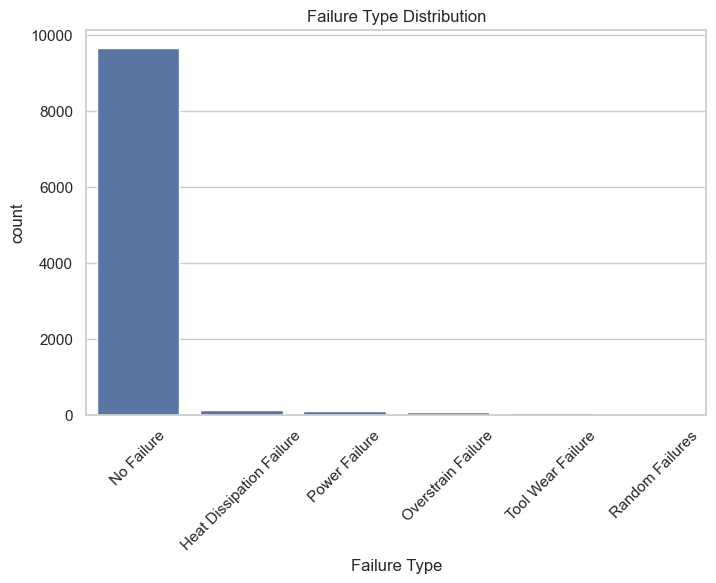

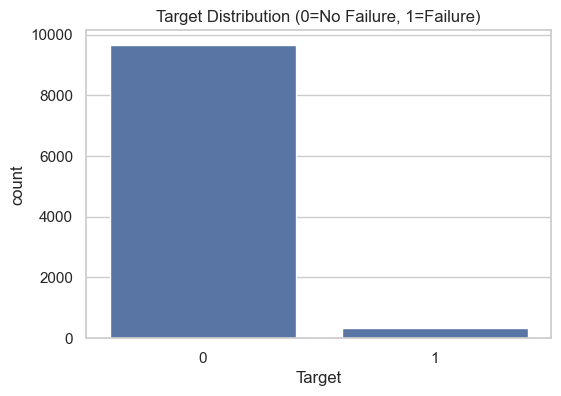

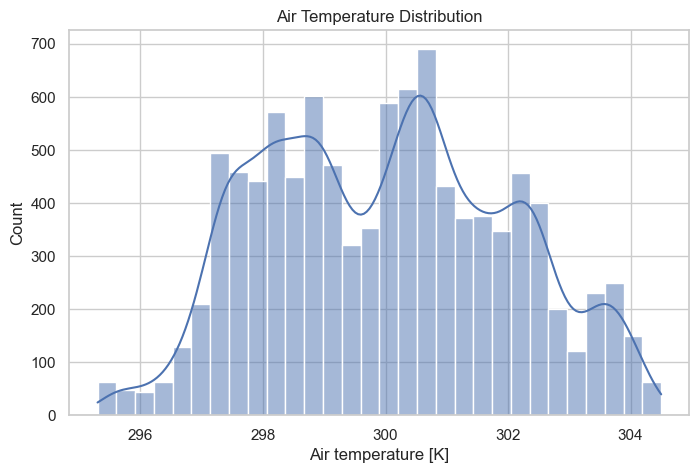

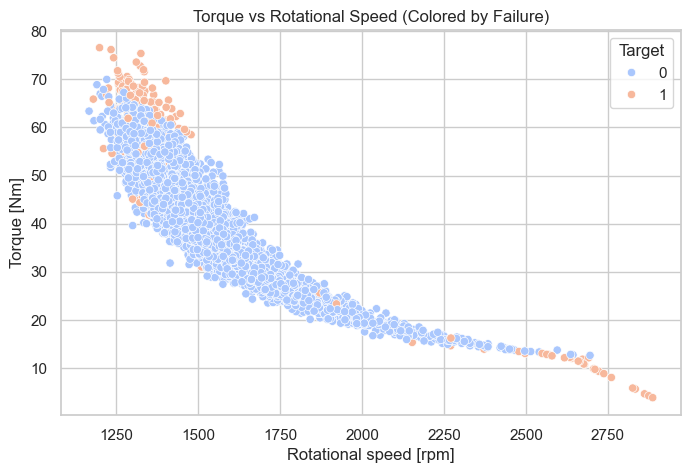

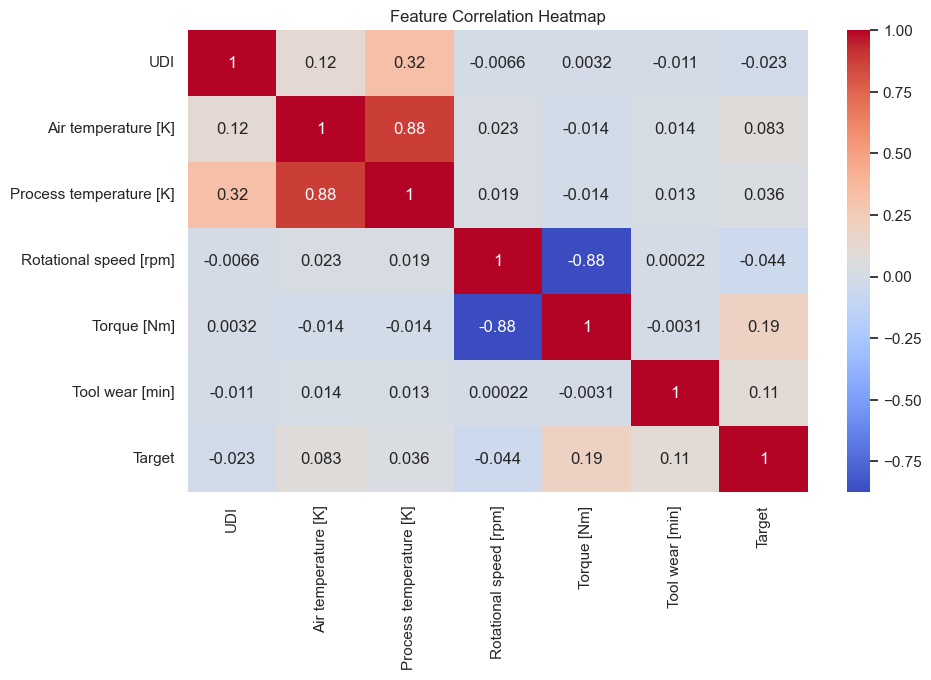

In [47]:
# Set a nice style
sns.set(style="whitegrid")

# 1. Plot Failure Type counts
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Failure Type', order=df['Failure Type'].value_counts().index)
plt.title("Failure Type Distribution")
plt.xticks(rotation=45)
plt.show()

# 2. Check class imbalance (Target)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Target')
plt.title("Target Distribution (0=No Failure, 1=Failure)")
plt.show()

# 3. Distribution of Air Temperature
plt.figure(figsize=(8,5))
sns.histplot(df['Air temperature [K]'], bins=30, kde=True)
plt.title("Air Temperature Distribution")
plt.show()

# 4. Relationship: Torque vs Rotational Speed
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Rotational speed [rpm]', y='Torque [Nm]', hue='Target', palette='coolwarm')
plt.title("Torque vs Rotational Speed (Colored by Failure)")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



Missing Values in Each Column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64
----------------------------------------
Summary Statistics:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800

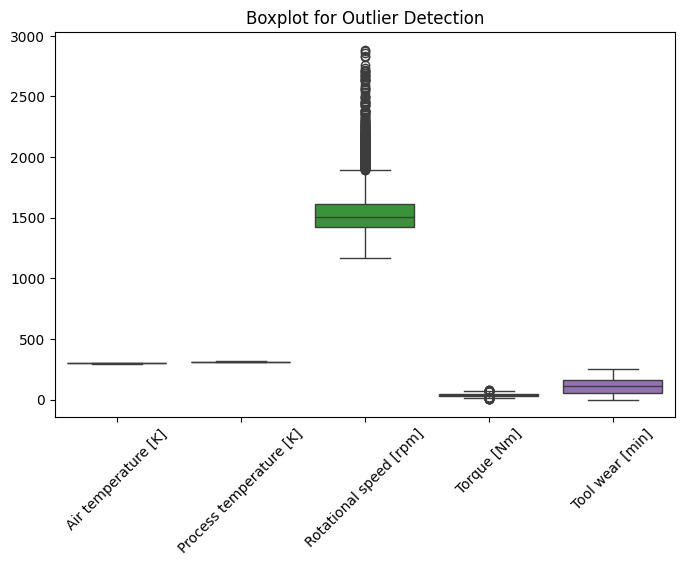

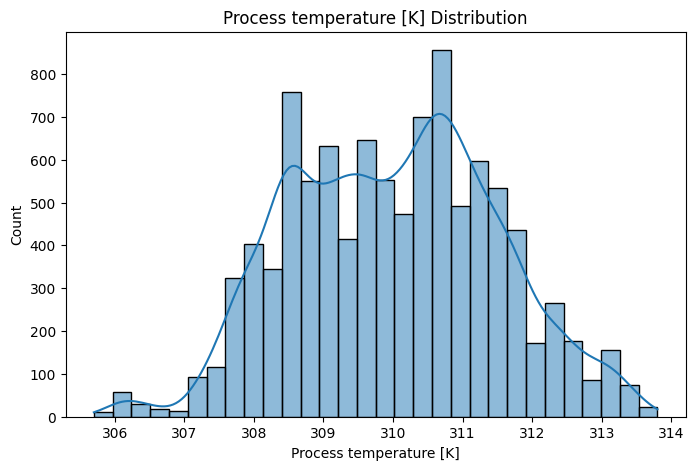

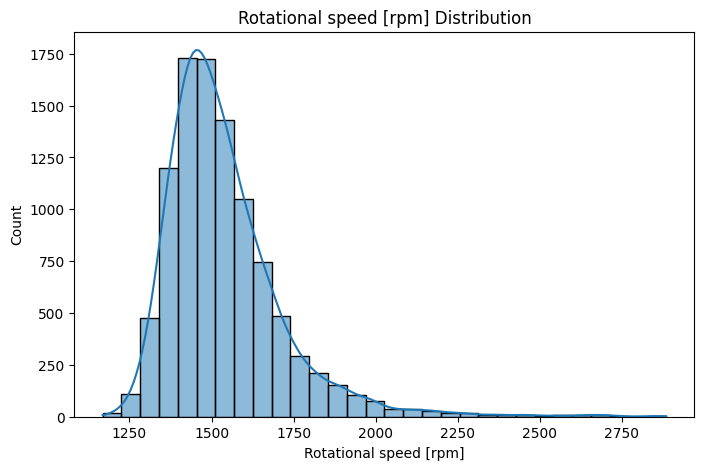

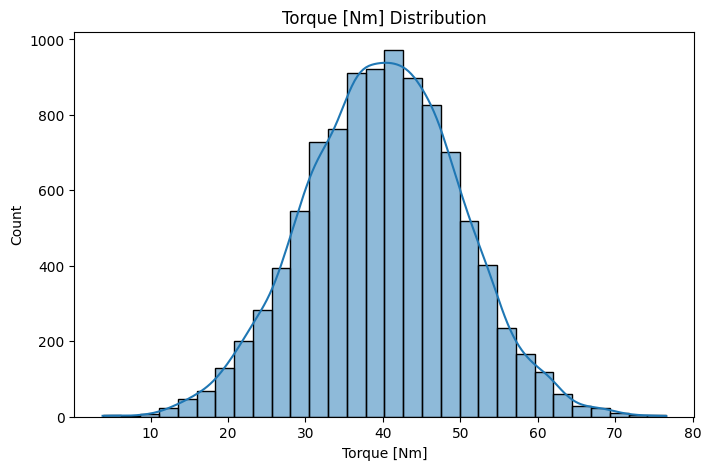

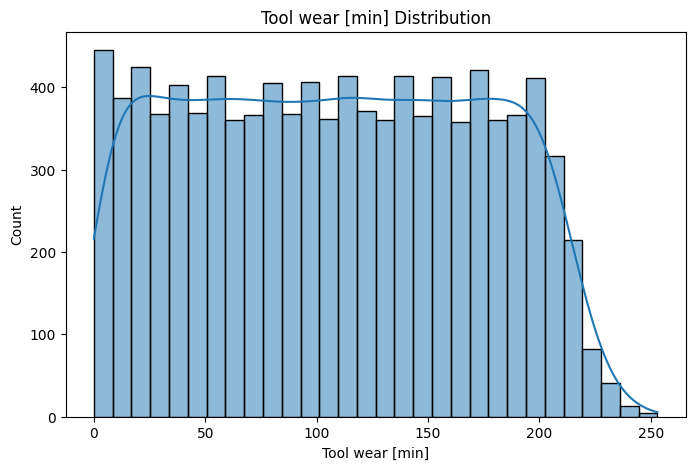

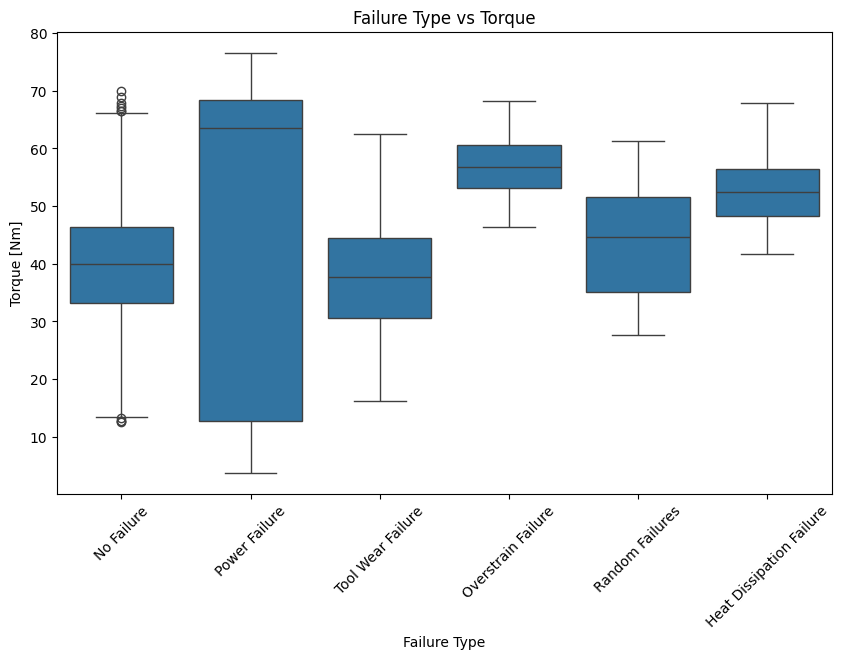

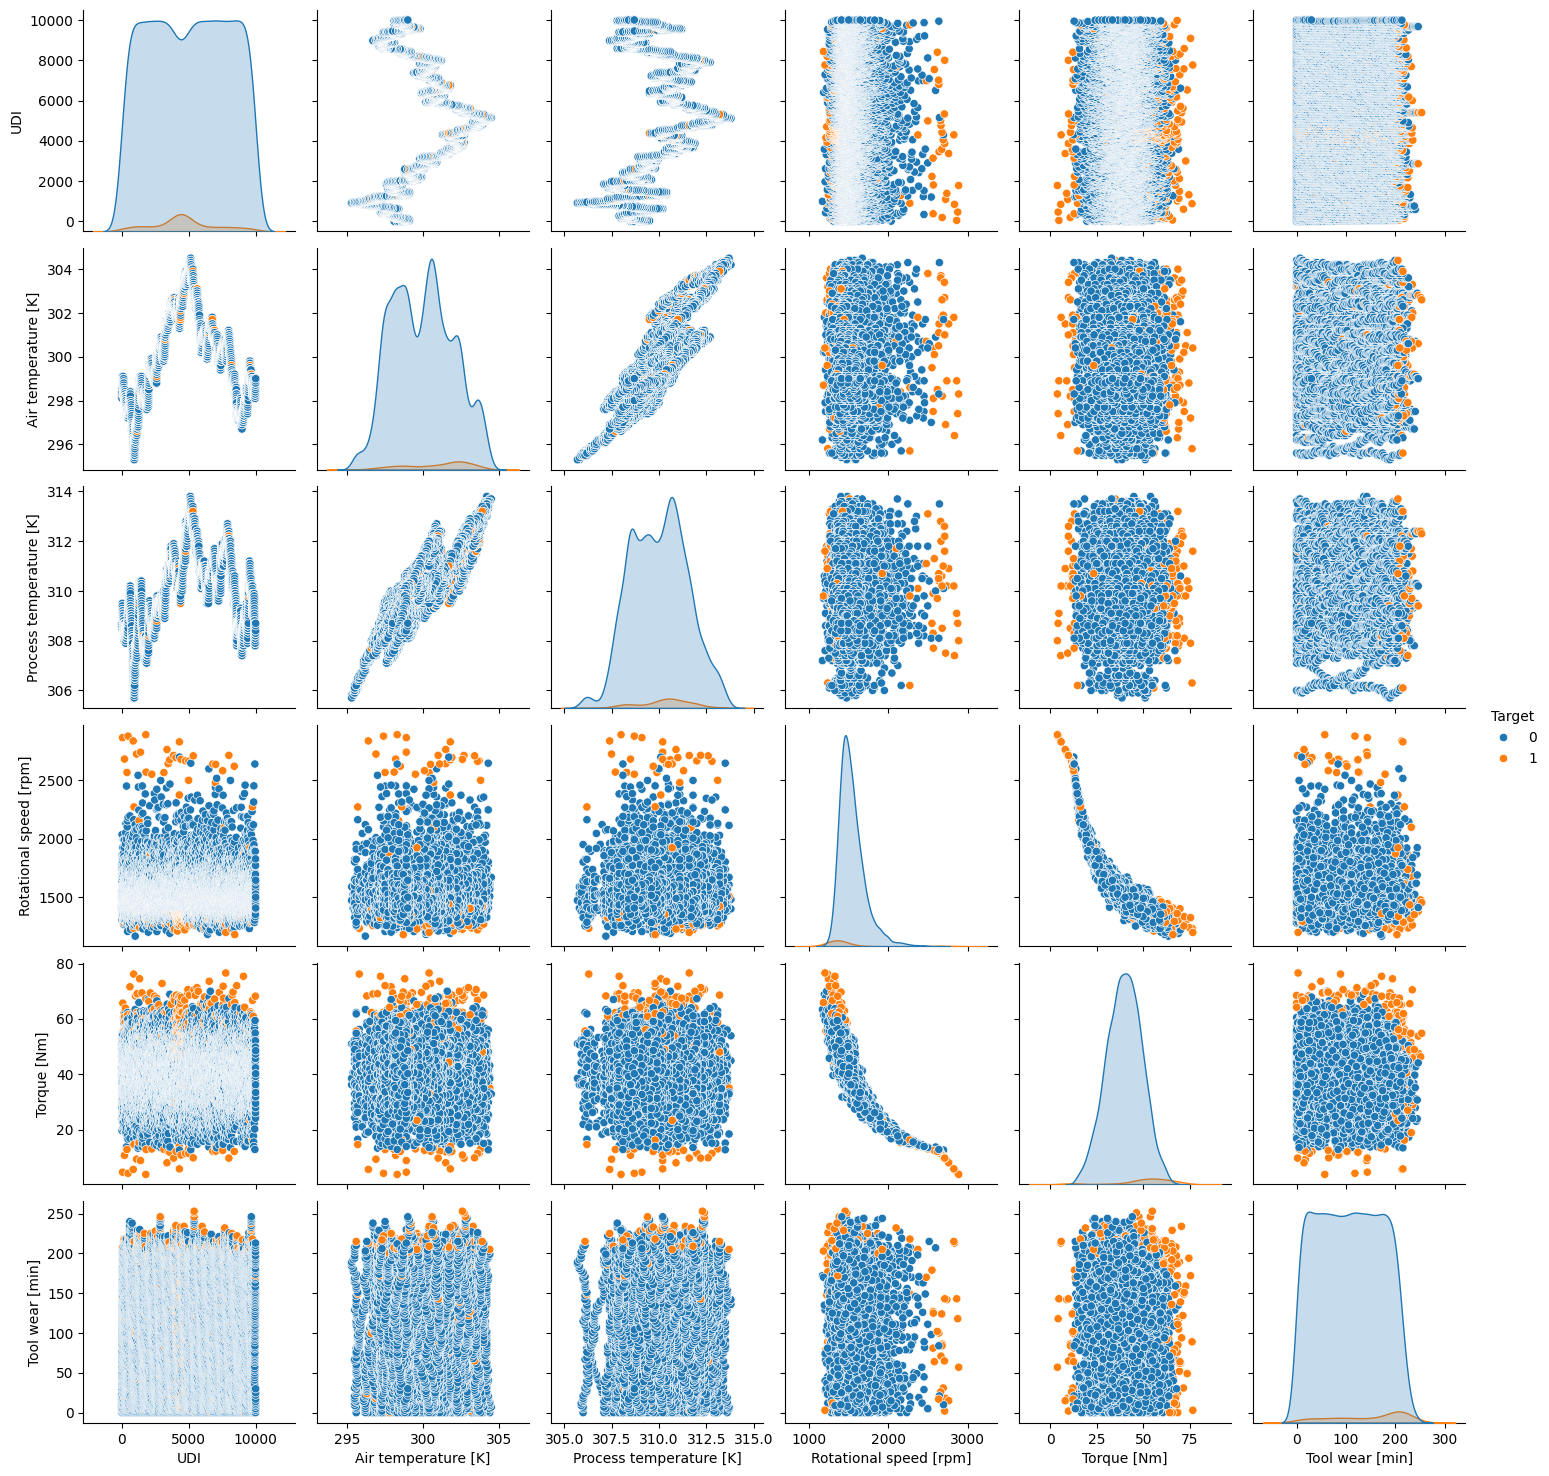

In [5]:
# 🔍 EXTRA EDA STEPS

# 1. Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())
print("-" * 40)

# 2. Summary statistics for numeric columns
print("Summary Statistics:")
print(df.describe())
print("-" * 40)

# 3. Boxplots for outlier detection
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
plt.title("Boxplot for Outlier Detection")
plt.xticks(rotation=45)
plt.show()

# 4. Distribution of other numeric columns
numeric_cols = ['Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

# 5. Boxplot of Failure Type vs Torque
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Failure Type', y='Torque [Nm]')
plt.title("Failure Type vs Torque")
plt.xticks(rotation=45)
plt.show()

# 6. Pairplot (quick overview, heavy on large datasets)
sns.pairplot(df, hue='Target', diag_kind='kde')
plt.show()


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# ==== 0) Select features (drop IDs and leak-prone columns) ====
# We predict Target using only inputs you'd have in real-time.
use_cols = [
    'Type',                      # categorical
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
X = df[use_cols].copy()
y = df['Target'].copy()

# ==== 1) Encode categorical ('Type') on TRAIN ONLY ====
le = LabelEncoder()

# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit encoder on train, transform both
X_train['Type'] = le.fit_transform(X_train['Type'])
X_test['Type']  = le.transform(X_test['Type'])

# ==== 2) Scale numeric features on TRAIN ONLY ====
num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# ==== 3) Handle imbalance with SMOTE on TRAIN ONLY ====
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Train (after SMOTE):", X_train_res.shape)
print("Test:", X_test.shape)
print("Train balance:\n", y_train_res.value_counts(normalize=True))


Train (after SMOTE): (15458, 6)
Test: (2000, 6)
Train balance:
 Target
0    0.5
1    0.5
Name: proportion, dtype: float64


[[1605  327]
 [  12   56]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1932
           1       0.15      0.82      0.25        68

    accuracy                           0.83      2000
   macro avg       0.57      0.83      0.58      2000
weighted avg       0.96      0.83      0.88      2000

ROC-AUC: 0.9034222384606017


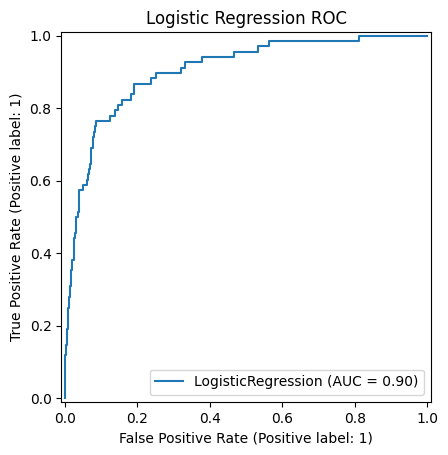

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("Logistic Regression ROC")
plt.show()


Confusion Matrix (Random Forest):
 [[1883   49]
 [  13   55]]

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.53      0.81      0.64        68

    accuracy                           0.97      2000
   macro avg       0.76      0.89      0.81      2000
weighted avg       0.98      0.97      0.97      2000

ROC-AUC Score (Random Forest): 0.9752960966995494


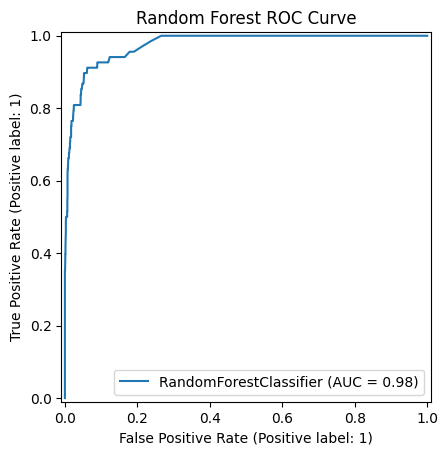

In [9]:
# ============================
# 1. Train Random Forest Classifier
# ============================
from sklearn.ensemble import RandomForestClassifier

# Initialize RF model
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Fit the model on SMOTE data
rf.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]

# ============================
# 2. Evaluation
# ============================
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score (Random Forest):", roc_auc_score(y_test, y_pred_rf_proba))

# ============================
# 3. Plot ROC Curve
# ============================
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()


In [11]:
import joblib

# Save
joblib.dump(scaler, "C:/python/machine_efficiency/models/scaler.pkl")
joblib.dump(rf, "C:/python/machine_efficiency/models/random_forest_model.pkl")
joblib.dump(le, "C:/python/machine_efficiency/models/label_encoder.pkl")

# Load
scaler = joblib.load("C:/python/machine_efficiency/models/scaler.pkl")
model = joblib.load("C:/python/machine_efficiency/models/random_forest_model.pkl")
le = joblib.load("C:/python/machine_efficiency/models/label_encoder.pkl")

print("✅ Model and scaler saved/loaded successfully!")


✅ Model and scaler saved/loaded successfully!
